In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from keras import models
from keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
X = np.load('/content/gdrive/MyDrive/pet-transformator/Keras/All_times_array.npy')
X_scaled = np.load('/content/gdrive/MyDrive/pet-transformator/Keras/All_times_scaled_array.npy')
train_labels = pd.read_csv("/content/gdrive/MyDrive/pet-transformator/Keras/train.csv")
train_labels.sort_values("id", inplace = True)
train_labels.set_index("id", inplace = True)
y = train_labels['category'].replace([1, 2, 3, 4], [0, 1, 2, 3])
print(f"X shape: {X.shape}")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"y shape: {y.shape}")

X shape: (2100, 420, 4)
X_scaled shape: (2100, 420, 4)
y shape: (2100,)


In [28]:
x_tr, x_test, y_tr, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size = 0.15, random_state = 1, stratify = y_tr)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")


x_train: (1428, 420, 4)
y_train: (1428, 4)
x_val: (252, 420, 4)
y_val: (252, 4)
x_test: (420, 420, 4)
y_test: (420,)


In [4]:
y_train

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [5]:
def train_and_report(model, lr_list, x_train, y_train, val_data, y_test, x_test,
                     loss,  metrics, optimizer=optimizers.Adam(),
                     batch_size=64, epochs=100, verbose=1):
  import time
  for lr in lr_list:

    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    K.set_value(model.optimizer.learning_rate, lr)
    
    start_time = time.time()

    history = model.fit(x_train,
                        y_train,
                        verbose=verbose,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)
    
    accuracy = round(accuracy_score(y_test,tf.argmax(input=model.predict(x_test), axis=1)),4)
    print('#########################')
    print('#########################')
    print(f'Learning_rate: {lr}')
    print("--- %s seconds ---" % (time.time() - start_time))

    print(classification_report(y_test,tf.argmax(input=model.predict(x_test), axis=1)))
    print(confusion_matrix(y_test,tf.argmax(input=model.predict(x_test), axis=1)))
    print(f'Accuracy: {accuracy}')

    #model.save(f'/content/gdrive/MyDrive/pet-transformator/Keras/1.{i}.Dense_(40,relu,{lr})_acc_{accuracy}.h5')
    #i += 1

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) +1)
    plt.figure(figsize=(20,5))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'Learning rate: {lr}, Accuracy: {accuracy}', fontsize = 25)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([.70,.99])
    plt.legend()

# **Простой LSTM**

In [6]:
from lr_finder import LRFinder

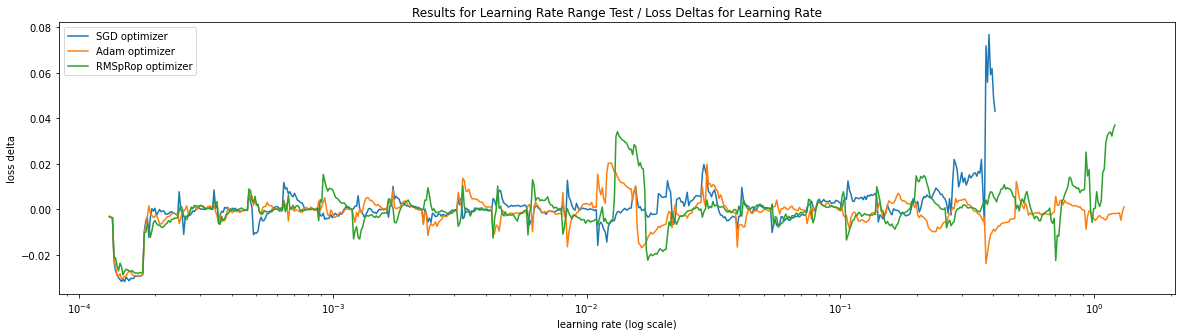

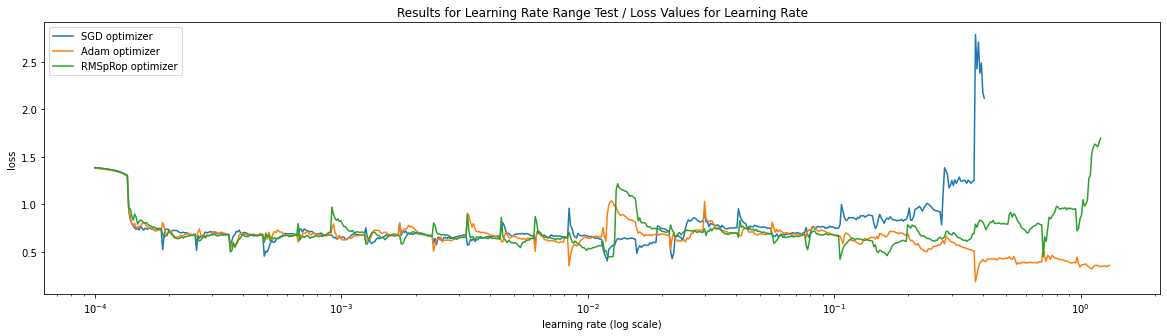

In [11]:
tests = [
  (optimizers.SGD(), 'SGD optimizer'),
  (optimizers.Adam(), 'Adam optimizer'),
  (optimizers.RMSprop(), 'RMSpRop optimizer')
]

test_learning_rates = []
test_losses = []
test_loss_changes = []
labels = []


for test_optimizer, label in tests:

    model = models.Sequential()
    model.add(layers.LSTM(50, activation='tanh', input_shape=(420, 4)))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    lr_finder = LRFinder(model)

    outputs = lr_finder.find(x_train, 
                         y_train, 
                         start_lr=0.0001, 
                         end_lr=1, 
                         batch_size=64, 
                         epochs=30, verbose=0)
    
    learning_rates = lr_finder.lrs
    losses = lr_finder.losses
    loss_changes = []

    moving_average = 20

    for i in range(moving_average, len(learning_rates)):
        loss_changes.append((losses[i] - losses[i - moving_average]) / moving_average)

    test_learning_rates.append(learning_rates)
    test_losses.append(losses)
    test_loss_changes.append(loss_changes)
    labels.append(label)

plt.figure(figsize=(20,5))
for i in range(0, len(test_learning_rates)):
  plt.plot(test_learning_rates[i][moving_average:], test_loss_changes[i], label=labels[i])
plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('loss delta')
plt.xlabel('learning rate (log scale)')
plt.title('Results for Learning Rate Range Test / Loss Deltas for Learning Rate')
plt.show()

# Generate plot for Loss Values
plt.figure(figsize=(20,5))
for i in range(0, len(test_learning_rates)):
  plt.plot(test_learning_rates[i], test_losses[i], label=labels[i])
plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('loss')
plt.xlabel('learning rate (log scale)')
plt.title('Results for Learning Rate Range Test / Loss Values for Learning Rate')
plt.show()

In [42]:
for value in sorted(list(enumerate(test_loss_changes[1])), key=lambda x: x[1])[:22]:
    print(test_learning_rates[1][value[0]], end=' ')
    print(f"({value[1]})")

0.00011163639 (-0.030716639757156373)
0.00011318308 (-0.03038793206214905)
0.0001147512 (-0.02956036329269409)
0.00010860613 (-0.02954809069633484)
0.00011634105 (-0.029482179880142213)
0.0001281041 (-0.029461359977722167)
0.00012462684 (-0.029335683584213255)
0.00012987894 (-0.02929584085941315)
0.00013167837 (-0.029276317358016966)
0.00012635351 (-0.02924949526786804)
0.00013350273 (-0.029246479272842407)
0.00013535237 (-0.029048198461532594)
0.00010712199 (-0.029027333855628966)
0.00012292377 (-0.028687775135040283)
0.000110110836 (-0.02845270335674286)
0.00011795292 (-0.02808014750480652)
0.00012124397 (-0.027596980333328247)
0.00011958712 (-0.02724620997905731)
0.000105658124 (-0.024965846538543703)
0.28442538 (-0.023958832025527954)
0.00010421427 (-0.02202000319957733)
0.28836602 (-0.01931641697883606)


#########################
#########################
Learning_rate: 0.285
--- 205.3449468612671 seconds ---
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       341
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        38

    accuracy                           0.81       420
   macro avg       0.20      0.25      0.22       420
weighted avg       0.66      0.81      0.73       420

[[341   0   0   0]
 [ 18   0   0   0]
 [ 23   0   0   0]
 [ 38   0   0   0]]
Accuracy: 0.8119


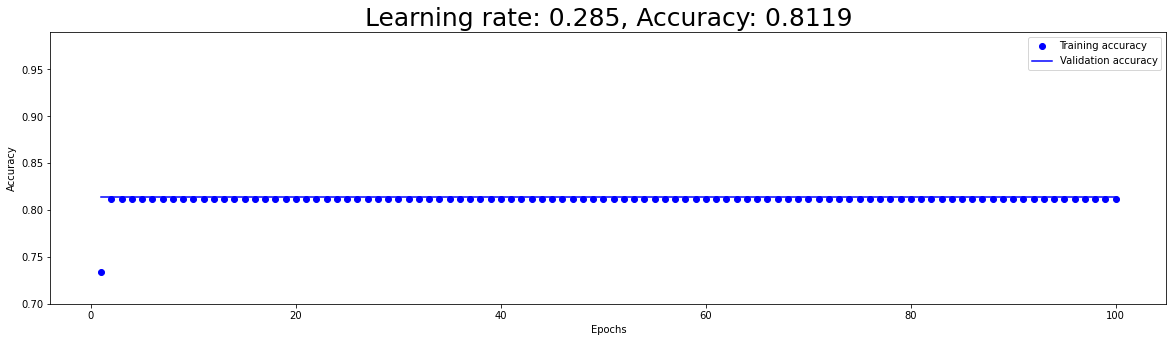

In [23]:
model = models.Sequential()
model.add(layers.LSTM(50, activation='tanh', input_shape=(420, 4)))
model.add(layers.Dense(4, activation='softmax'))

train_and_report(model, lr_list=[0.285], x_train=x_train, y_train=y_train, val_data=(x_val, y_val), 
                 y_test=y_test, x_test=x_test, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=64, epochs=100, verbose=0)

# **Сложенный LSTM**

#########################
#########################
Learning_rate: 0.001
--- 1796.39337849617 seconds ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       341
           1       1.00      0.67      0.80        18
           2       0.95      0.91      0.93        23
           3       0.78      0.74      0.76        38

    accuracy                           0.95       420
   macro avg       0.93      0.83      0.87       420
weighted avg       0.95      0.95      0.95       420

[[339   0   0   2]
 [  0  12   0   6]
 [  2   0  21   0]
 [  9   0   1  28]]
Accuracy: 0.9524


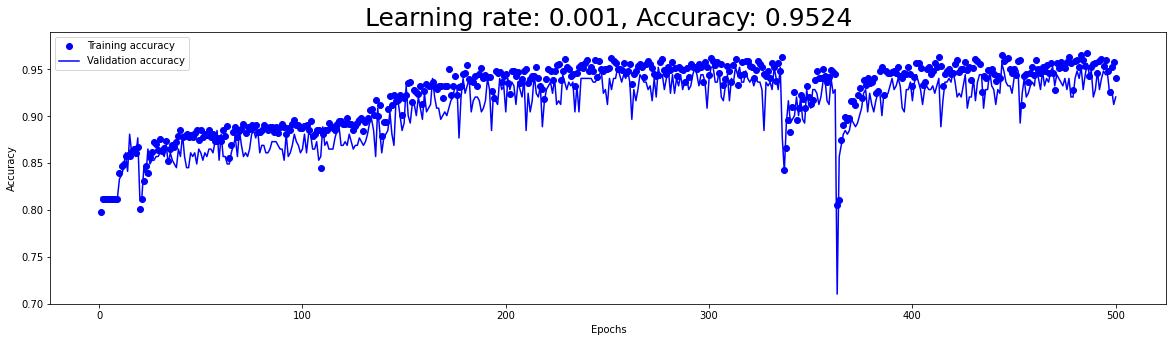

In [11]:
model = models.Sequential()
model.add(layers.LSTM(64, dropout=0.1, return_sequences=True, activation='tanh', input_shape=(420, 4)))
model.add(layers.LSTM(32, dropout=0.1, activation='tanh'))
model.add(layers.Dense(4, activation='softmax'))

train_and_report(model, lr_list=[0.001], x_train=x_train, y_train=y_train, val_data=(x_val, y_val), 
                 y_test=y_test, x_test=x_test, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=64, epochs=500, verbose=0)

In [12]:
model.save('/content/gdrive/MyDrive/pet-transformator/Keras/2.1.Stacked_LSTM_(64,32,tanh,0.001)_acc_0.9524.h5')

# **Двунаправленный LSTM**

#########################
#########################
Learning_rate: 0.001
--- 1241.0013058185577 seconds ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       341
           1       0.93      0.78      0.85        18
           2       0.94      0.70      0.80        23
           3       0.67      0.76      0.72        38

    accuracy                           0.93       420
   macro avg       0.88      0.80      0.83       420
weighted avg       0.94      0.93      0.93       420

[[333   0   0   8]
 [  0  14   0   4]
 [  5   0  16   2]
 [  7   1   1  29]]
Accuracy: 0.9333


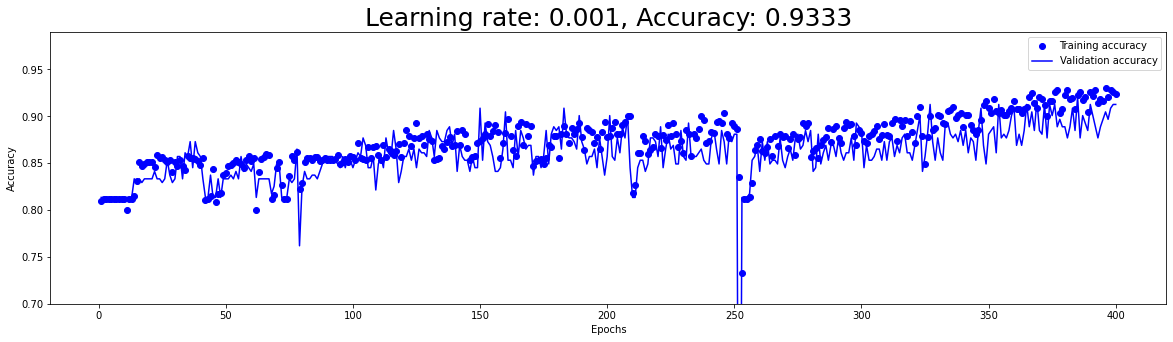

In [15]:
model = models.Sequential()
model.add(layers.Bidirectional(layers.LSTM(100, dropout=0.1, activation='tanh', input_shape=(420, 4))))
model.add(layers.Dense(4, activation='softmax'))
train_and_report(model, lr_list=[0.001], x_train=x_train, y_train=y_train, val_data=(x_val, y_val), 
                 y_test=y_test, x_test=x_test, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=64, epochs=400, verbose=0)

#########################
#########################
Learning_rate: 0.001
--- 1255.7887034416199 seconds ---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       341
           1       1.00      0.89      0.94        18
           2       0.91      0.91      0.91        23
           3       0.73      0.97      0.83        38

    accuracy                           0.96       420
   macro avg       0.91      0.94      0.92       420
weighted avg       0.97      0.96      0.96       420

[[329   0   1  11]
 [  0  16   0   2]
 [  1   0  21   1]
 [  0   0   1  37]]
Accuracy: 0.9595


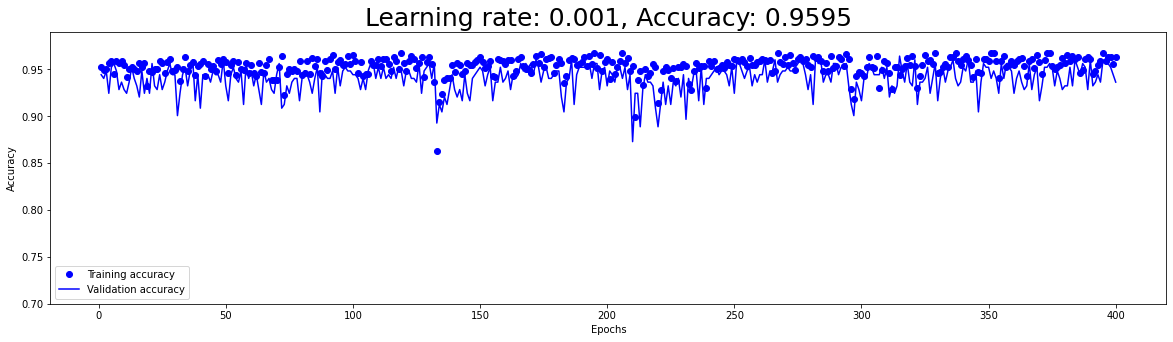

In [21]:
lr = 0.001
import time
start_time = time.time()

history = model.fit(x_train,
                    y_train,
                    verbose=0,
                    epochs=400,
                    batch_size=64,
                    validation_data=(x_val, y_val))

accuracy = round(accuracy_score(y_test,tf.argmax(input=model.predict(x_test), axis=1)),4)
print('#########################')
print('#########################')
print(f'Learning_rate: {lr}')
print("--- %s seconds ---" % (time.time() - start_time))
print(classification_report(y_test,tf.argmax(input=model.predict(x_test), axis=1)))
print(confusion_matrix(y_test,tf.argmax(input=model.predict(x_test), axis=1)))
print(f'Accuracy: {accuracy}')
#model.save(f'/content/gdrive/MyDrive/pet-transformator/Keras/1.{i}.Dense_(40,relu,{lr})_acc_{accuracy}.h5')
#i += 
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) +1)
plt.figure(figsize=(20,5))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title(f'Learning rate: {lr}, Accuracy: {accuracy}', fontsize = 25)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([.70,.99])
plt.legend()

# **CNN LSTM**

In [29]:
x_train1 = x_train.reshape(x_train.shape[0], 1, 420, 4)
x_val1 = x_val.reshape(x_val.shape[0], 1, 420, 4)
x_test1 = x_test.reshape(x_test.shape[0], 1, 420, 4)

#########################
#########################
Learning_rate: 0.001
--- 264.8189170360565 seconds ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       341
           1       0.82      1.00      0.90        18
           2       0.82      1.00      0.90        23
           3       0.90      0.74      0.81        38

    accuracy                           0.96       420
   macro avg       0.88      0.93      0.90       420
weighted avg       0.96      0.96      0.96       420

[[334   0   4   3]
 [  0  18   0   0]
 [  0   0  23   0]
 [  5   4   1  28]]
Accuracy: 0.9595


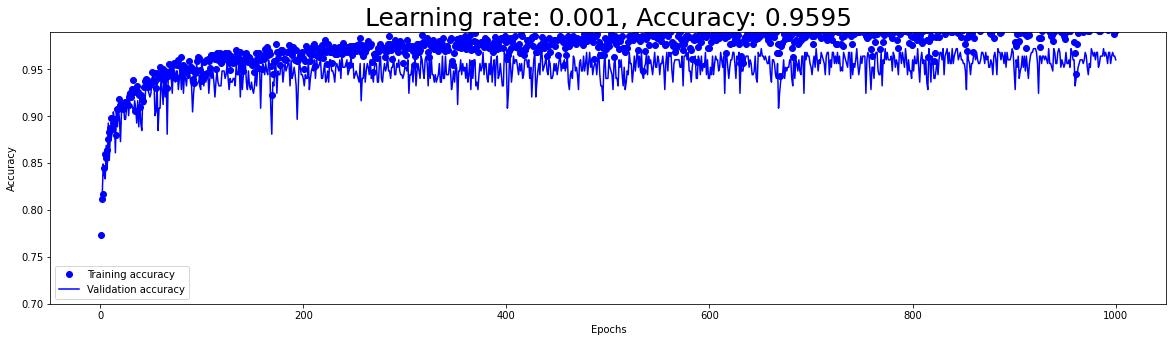

In [32]:
model = models.Sequential()
model.add(layers.TimeDistributed(layers.Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 420, 4)))
model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(50, activation='tanh'))
model.add(layers.Dense(4, activation='softmax'))
train_and_report(model, lr_list=[0.001], x_train=x_train1, y_train=y_train, val_data=(x_val1, y_val), 
                 y_test=y_test, x_test=x_test1, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=64, epochs=1000, verbose=0)

In [34]:
model.save('/content/gdrive/MyDrive/pet-transformator/Keras/2.2.CNN_LSTM__acc_0.9595.h5')

# **ConvLSTM2D**

In [35]:
x_train2 = x_train.reshape(x_train.shape[0], 1, 1, 420, 4)
x_val2 = x_val.reshape(x_val.shape[0], 1, 1, 420, 4)
x_test2 = x_test.reshape(x_test.shape[0], 1, 1, 420, 4)

#########################
#########################
Learning_rate: 0.001
--- 695.9393856525421 seconds ---
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       341
           1       0.94      0.94      0.94        18
           2       0.87      0.87      0.87        23
           3       0.73      0.95      0.83        38

    accuracy                           0.95       420
   macro avg       0.89      0.93      0.90       420
weighted avg       0.96      0.95      0.96       420

[[328   0   2  11]
 [  0  17   0   1]
 [  1   1  20   1]
 [  1   0   1  36]]
Accuracy: 0.9548


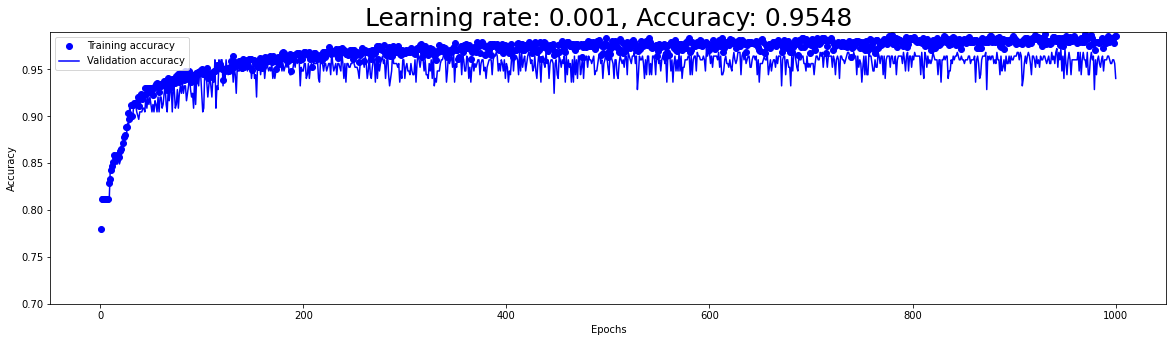

In [39]:
model = models.Sequential()
model.add(layers.ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, 420, 4)))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax'))
train_and_report(model, lr_list=[0.001], x_train=x_train2, y_train=y_train, val_data=(x_val2, y_val), 
                 y_test=y_test, x_test=x_test2, loss='categorical_crossentropy', metrics=['accuracy'],
                 optimizer=optimizers.Adam(), batch_size=64, epochs=1000, verbose=0)

In [40]:
model.save('/content/gdrive/MyDrive/pet-transformator/Keras/2.2.ConvLSTM2D__acc_0.9548.h5')